In [2]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
# 1a config model

def config_model(degseq):
    G = nx.Graph()
    # copy of degseq to avoid writing over original
    ds_copy = list(degseq)

    # create nodes to populate G with
    N = len(degseq)
    G.add_nodes_from(range)

    node_ids = list(G.nodes())

    while sum(ds_copy) > 0: # until every stub has been matched
        stubs = random.sample(node_ids, 2)
        i, j = stubs
        if ds_copy[i] > 0 and ds_copy[j] > 0:
            G.add_edge(i, j)
            ds_copy[i] -= 1
            ds_copy[j] -= 1
        else:
            continue

In [ ]:
#1b chung lu

def chung_lu(degseq): 
    # same as before
    G = nx.Graph()
    ds_copy = list(degseq)
    N = len(ds_copy)
    G.add_nodes_from(range(N))

    for i in range(N):
        for j in range(i+1, N): # nested for loop to get all possible combos w/o visiting any twice
            ki = ds_copy[i]
            ji = ds_copy[j]
            pr = (ki*ji)/sum(ds_copy) # 2m = sum of degree sequence
            if random.random()< pr:
                G.add_edge(i, j)
    return G

In [3]:
# 1c model diff (setup)

degrees=[8,5,5,4,3,2,2,2,1,1,1,1,1,1,1]
# init lists to contain samples
config_graphs = []
cl_graphs = []

# collecting samples
for i in range(1000):
    # using bui
    G = nx.configuration_model(degrees)
    config_graphs.append(G)

for i in range(1000):
    G = nx.expected_degree_graph(degrees, selfloops=False)
    cl_graphs.append(G)

def avg_adj_matrix(sample): # function to calculate avg adjacency matrix
    n = len(degrees)
    sum_matrix = np.zeros((n, n)) # zero matrix to act as "running total"
    for g in sample:
        sum_matrix += nx.to_numpy_array(g) # convert to array and add to sum
    avg_matrix = sum_matrix / len(sample)
    return avg_matrix

config_avg_adj = avg_adj_matrix(config_graphs)
cl_avg_adj = avg_adj_matrix(cl_graphs)



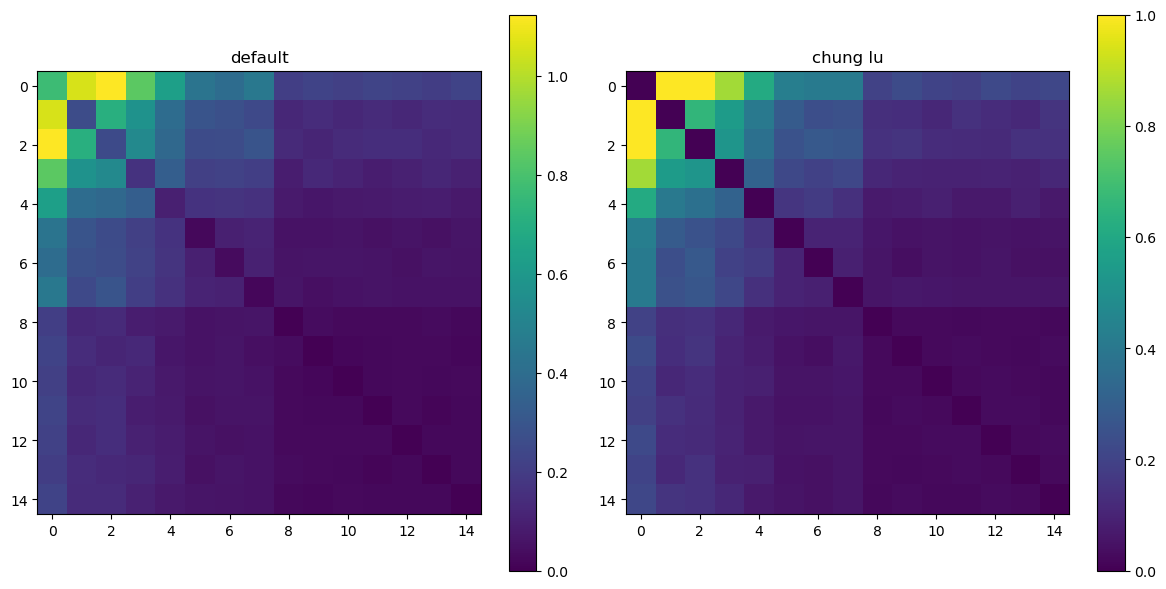

In [8]:
# 1c model diff (heatmap)
fig, ax = plt.subplots(1, 2, figsize=(12,6))

im1 = ax[0].imshow(config_avg_adj, cmap='viridis')
fig.colorbar(im1, ax=ax[0])
ax[0].set_title('default')

im2 = ax[1].imshow(cl_avg_adj, cmap='viridis')
fig.colorbar(im2, ax=ax[1])
ax[1].set_title('chung lu')

plt.tight_layout()

differences:
1. chung lu does not preserve exact deg dist (how close is approximate?)
2. edge probs are independent in chung lu
3. no multi edges/self loop in chung lu
4. default considers all possible incarnations of a network that satisfy its constraints as equally probable

metrics:
deg dist should be about same
cc diff
